In [1]:
### TODO: calculate F_hourly
import intake
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from skimage.segmentation import find_boundaries
import xesmf as xe
import dask.array as da
import scipy
from dask.distributed import progress
import pyproj
import warnings
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
from dask.distributed import Client
import metpy.calc as mpcalc

In [2]:
import os
import sys

user_id = os.environ['USER']
sys.path.append(f'/home/548/{user_id}/working/hk25-AusNode-coastal/')

In [3]:
client = Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42449 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42449/status,
Dashboard: /proxy/42449/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36227,Workers: 7
Dashboard: /proxy/42449/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40775,Total threads: 1
Dashboard: /proxy/43997/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40073,


In [5]:
#Open some sample data
ds = xr.open_zarr("/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr/").sel(
    time=slice("2020-12-01 00:00","2020-12-01 23:00"))
ds

<xarray.Dataset> Size: 29GB
Dimensions:  (cell: 12582912, time: 24)
Coordinates:
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    crs      float64 8B ...
  * time     (time) datetime64[ns] 192B 2020-12-01 ... 2020-12-01T23:00:00
Data variables: (12/26)
    clivi    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 1GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

In [6]:
from sea_breeze_code.utils import interpolate_field_lon_lat

In [9]:
ds = egh.attach_coords(ds)

In [10]:
angles = xr.open_zarr("/g/data/nf33/hk25_AusNode_coastal/um_MC_angles_z10.zarr/")

In [11]:
nside = hp.get_nside(ds.uas)
ncells = ds.cell.shape[0]
nlats = int(np.round(np.sqrt(ncells/2)))
nlons = int(np.round(2*np.sqrt(ncells/2)))
target_lats = np.linspace(
    -90,
    90,
    nlats
)
target_lons = np.linspace(
    0,
    360,
    nlons,
)

In [15]:
points = np.stack((ds.lon, ds.lat), axis=1)

In [18]:
lon2, lat2 = np.meshgrid(target_lons, target_lats)

In [21]:
ds.uas.shape

(24, 12582912)

In [24]:
from scipy.interpolate import NearestNDInterpolator 

NearestNDInterpolator(points, ds.uas.isel(time=0))(lon2, lat2)

array([[-6.47324753, -6.47324753, -6.47324753, ..., -6.47324753,
        -6.47324753, -6.47324753],
       [-6.35141039, -6.47324753, -6.47324753, ..., -6.47324753,
        -6.47324753, -6.375     ],
       [-6.35141039, -6.35141039, -6.47324753, ..., -6.47324753,
        -6.375     , -6.375     ],
       ...,
       [-0.89858979, -0.89858979, -0.875     , ..., -1.        ,
        -1.        , -1.        ],
       [-0.89858979, -0.875     , -0.875     , ..., -1.        ,
        -1.        , -1.        ],
       [-0.875     , -0.875     , -0.875     , ..., -1.        ,
        -1.        , -1.        ]])

In [14]:
target_lons = target_lons[(target_lons>=90) & (target_lons<=170)]
target_lats = target_lats[(target_lats>=-15) & (target_lats<=10)]

In [15]:
from sea_breeze_code.utils import get_nn_lon_lat_index

In [ ]:
#Do the interpolation and return the healpix cell indices
target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

#Define the regridded land sea mask
#lsm = ((ds.sftlf.isel(cell=target_inds))>0.5)

#Regrid u, v and hus in the same way as the land-sea mask
uas_regrid = ds.uas.isel(cell=target_inds)
vas_regrid = ds.vas.isel(cell=target_inds)
hus_regrid = ds.huss.isel(cell=target_inds)
angle_regrid = angle.angle_interp.isel(cell=target_inds)

2025-05-15 13:30:36,341 - distributed.utils_perf - WARNING - full garbage collections took 64% CPU time recently (threshold: 10%)
2025-05-15 13:30:36,763 - distributed.utils_perf - WARNING - full garbage collections took 65% CPU time recently (threshold: 10%)
2025-05-15 13:30:37,239 - distributed.utils_perf - WARNING - full garbage collections took 65% CPU time recently (threshold: 10%)
2025-05-15 13:30:37,761 - distributed.utils_perf - WARNING - full garbage collections took 68% CPU time recently (threshold: 10%)
2025-05-15 13:30:38,244 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2025-05-15 13:30:38,681 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2025-05-15 13:30:39,126 - distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
2025-05-15 13:30:39,595 - distributed.utils_perf - WARNING - full garbage collections took

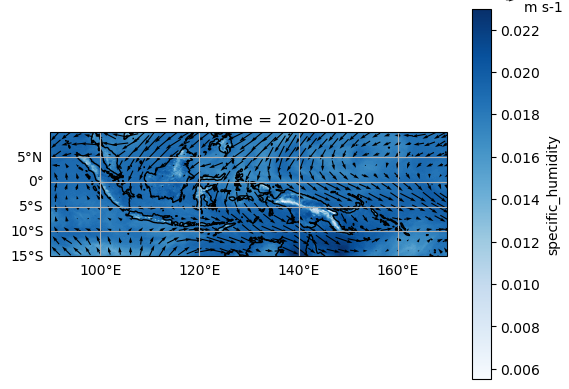

In [26]:
#Plot vprime and associated wind vectors for the first model time step
ax=plt.axes(projection=ccrs.PlateCarree())
im=hus_regrid.isel(time=0).plot(ax=ax, transform = ccrs.PlateCarree(),cmap="Blues")
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=0).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])

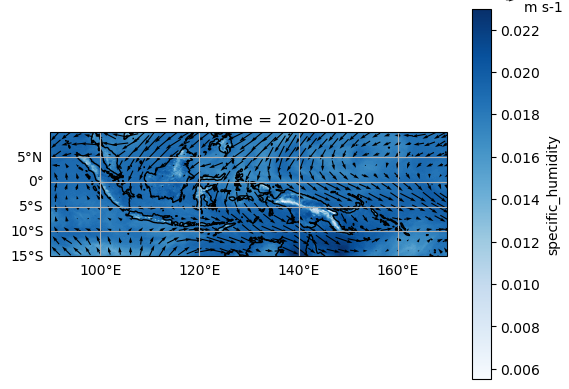

In [26]:
#Plot vprime and associated wind vectors for the first model time step
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_regrid.plot(ax=ax, transform = ccrs.PlateCarree(),cmap="twilight_shifted")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])

In [17]:
from sea_breeze_code.sea_breeze_funcs import kinematic_frontogenesis

F = kinematic_frontogenesis(hus_regrid,
                        uas_regrid,
                        vas_regrid
                       )

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futur

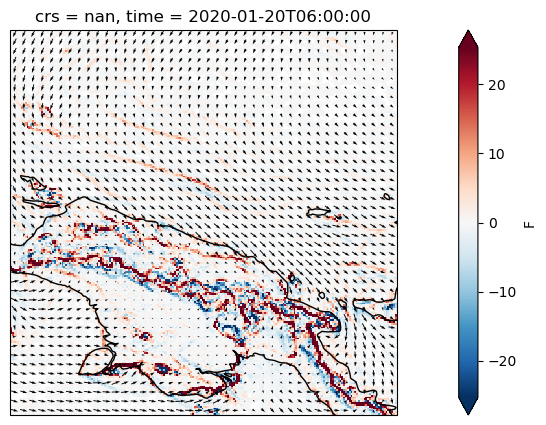

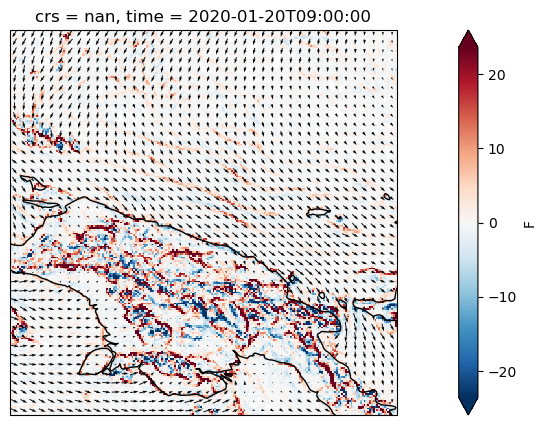

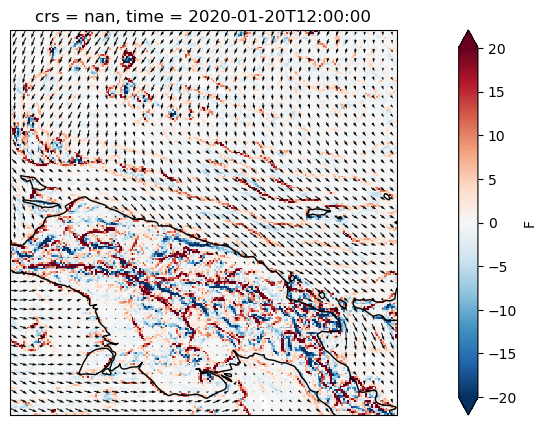

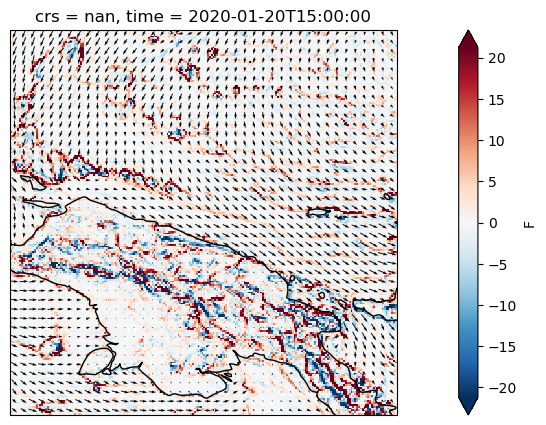

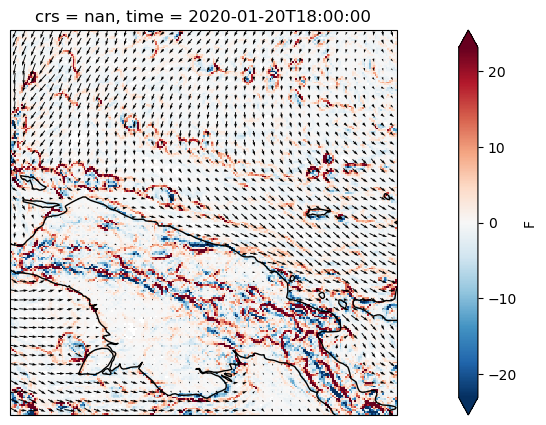

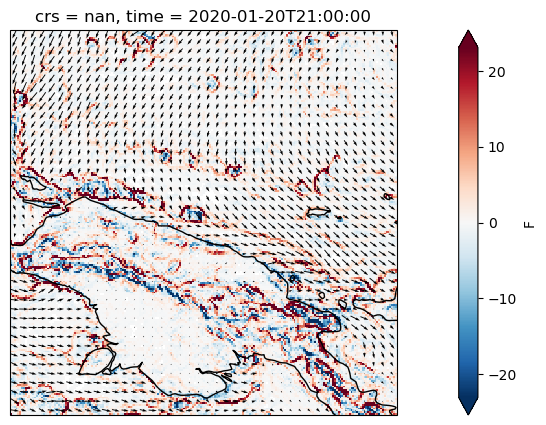

In [33]:
for t in [6,9,12,15,18,21]:

    plt.figure(figsize=[16,5])
    
    ax=plt.axes(projection=ccrs.PlateCarree())
    F.sel(lat=slice(-10,5),lon=slice(135,150)).F.isel(time=t).plot(ax=ax,robust=True)
    xr.Dataset(
        {"u":uas_regrid.sel(lat=slice(-10,5),lon=slice(135,150)),
        "v":vas_regrid.sel(lat=slice(-10,5),lon=slice(135,150))}).isel(time=t).coarsen(
        {"lat":5,"lon":5},boundary="pad").mean()\
        .plot.quiver(
        x="lon",
        y="lat",
        u="u",
        v="v")
    ax.coastlines()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


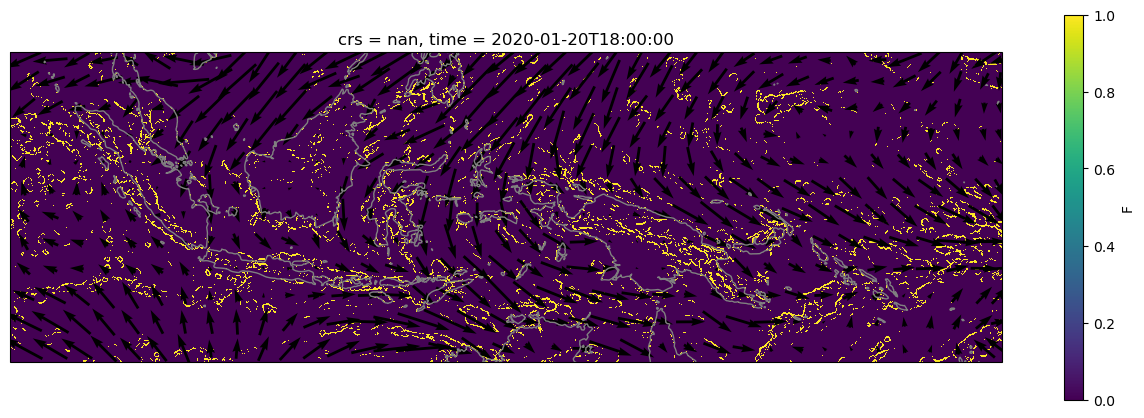

In [35]:
t=18

plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
(F.F.isel(time=t)>10).plot(ax=ax)
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=t).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines(color="grey")

In [44]:
from sea_breeze_code.sea_breeze_filters import percentile, filter_3d

In [42]:
print(np.array(percentile(F.F)))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 260.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[44.20227274]


In [57]:
mask = filter_3d(F.F,threshold="fixed",threshold_value=10,orientation_filter=False,save_mask=False,props_df_out_path='/scratch/ng72/ab4502/tmp/props_df.csv')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 16.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 30.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


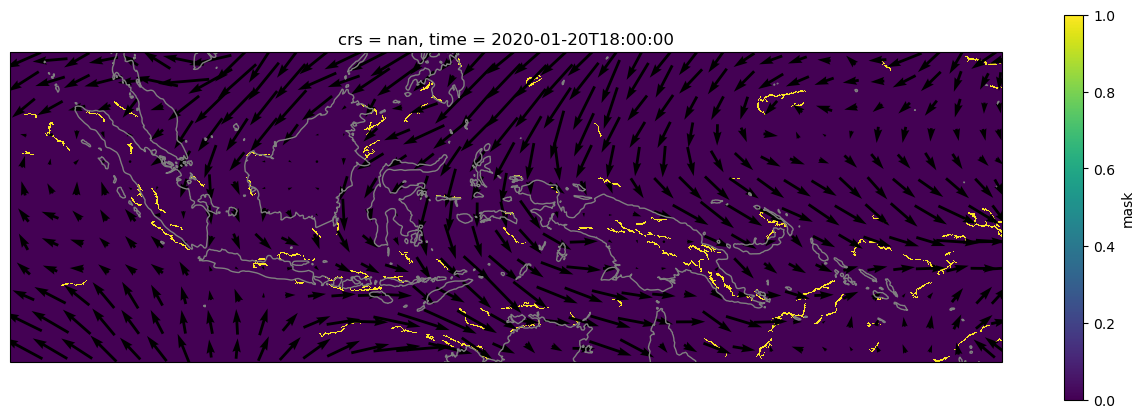

In [58]:
t=18

plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
mask.mask.isel(time=t).plot(ax=ax)
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=t).coarsen(
    {"lat":30,"lon":30},boundary="pad").mean()\
    .plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines(color="grey")


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 263.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.p

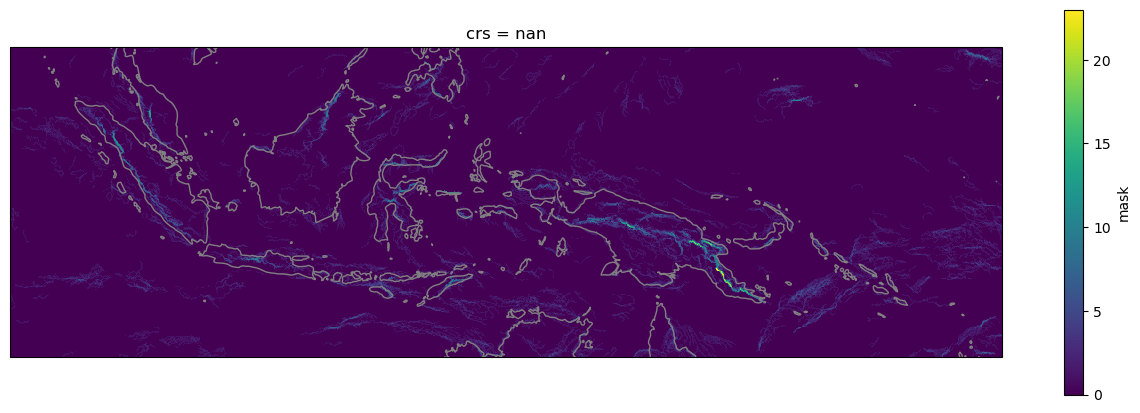

In [59]:
plt.figure(figsize=[16,5])

ax=plt.axes(projection=ccrs.PlateCarree())
mask.mask.sum("time").plot(ax=ax)
ax.coastlines(color="grey")


In [56]:
mask

<xarray.Dataset> Size: 50MB
Dimensions:          (time: 24, lat: 348, lon: 1115)
Coordinates:
  * time             (time) datetime64[ns] 192B 2020-01-20 ... 2020-01-20T23:...
  * lat              (lat) float64 3kB -14.97 -14.9 -14.83 ... 9.801 9.872 9.944
  * lon              (lon) float64 9kB 90.0 90.07 90.14 ... 169.8 169.9 170.0
    cell             (lat, lon) int64 3MB dask.array<chunksize=(348, 1115), meta=np.ndarray>
    crs              float64 8B dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    all_labels       (time, lat, lon) int16 19MB dask.array<chunksize=(1, 348, 1115), meta=np.ndarray>
    filtered_labels  (time, lat, lon) int16 19MB dask.array<chunksize=(1, 348, 1115), meta=np.ndarray>
    mask             (time, lat, lon) bool 9MB dask.array<chunksize=(1, 348, 1115), meta=np.ndarray>
Attributes: (12/25)
    orientation_filter:                False
    aspect_filter:                     True
    area_filter:                       True
    time_filter:                       False
    dist_to_coast_filter:              False
    land_sea_temperature_filter:       False
    ...                                ...
    wind_change_thresh:                0
    max_distance_to_coast_thresh:      300
    min_distance_to_coast_thresh:      0
    propagation_speed_thresh:          0
    land_sea_temperature_radius:       50
    area_filter_units:                 pixels